"""
# Gaussian Belief Propagation Library

Author: [Joseph Ortiz](https://joeaortiz.github.io/)

License: [Creative Commons Attribution 4.0 International
](https://github.com/gaussianBP/gaussianBP.github.io/blob/master/LICENSE)

This library is provided as accompanying code to our article [A visual introduction to Gaussian Belief Propagation
](https://gaussianbp.github.io/).
"""

In [3]:
# Commented out IPython magic to ensure Python compatibility.
#@title Imports
import numpy as np
import os
import matplotlib.pyplot as plt

from typing import List, Callable, Optional, Union

import jax.numpy as jnp
from jax import random as jrand
from jax import config

from factor_graph import FactorGraph, GBPSettings
from gaussian import MeasModel, SquaredLoss

# Uncomment below expression to enforce CPU runtime
# config.update('jax_platform_name', 'cpu')

# """1D Line Fitting Example"""

## Create Custom factors

In [4]:
def height_meas_fn(x: jnp.array, gamma: jnp.array):
    gamma = gamma.squeeze()
    J = jnp.array([1-gamma, gamma])
    return J @ x.reshape(-1,1)

def height_jac_fn(x: jnp.array, gamma: jnp.array):
    gamma = gamma.squeeze()
    return jnp.array([[1-gamma, gamma]])

class HeightMeasurementModel(MeasModel):
    def __init__(self, loss: SquaredLoss, gamma: jnp.array) -> None:
        MeasModel.__init__(self, height_meas_fn, height_jac_fn, loss, gamma)
        self.linear = True

def smooth_meas_fn(x: jnp.array):
    return jnp.array([x[1] - x[0]])

def smooth_jac_fn(x: jnp.array):
    return jnp.array([[-1., 1.]])

class SmoothingModel(MeasModel):
    def __init__(self, loss: SquaredLoss) -> None:
        MeasModel.__init__(self, smooth_meas_fn, smooth_jac_fn, loss)
        self.linear = True

## Set parameters

In [5]:
n_varnodes = 20
x_range = 10
n_measurements = 15

gbp_settings = GBPSettings(
    damping = 0.1,
    beta = 0.01,
    num_undamped_iters = 1,
    min_linear_iters = 1,
    dropout = 0.0,
)

## Gaussian noise measurement model parameters:

In [6]:
prior_cov = jnp.array([10.])
data_cov = jnp.array([0.05]) 
smooth_cov = jnp.array([0.1])
data_std = jnp.sqrt(data_cov)

## Create measurements {vertical-output: true}

In [7]:
key = jrand.PRNGKey(42)
meas_x = jrand.randint(key, [n_measurements], 0, x_range)
key, subkey = jrand.split(key)
meas_y = jnp.sin(meas_x) + jrand.normal(key, [n_measurements])*data_std

## Plot measurements

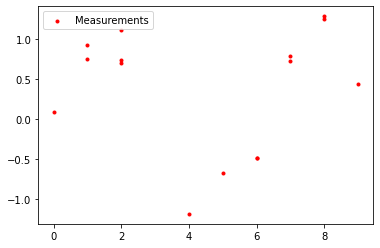

In [8]:
plt.scatter(meas_x, meas_y, color="red", label="Measurements", marker=".")
plt.legend()
plt.show()

## Create factor graph {vertical-output: true}

In [9]:
fg = FactorGraph(gbp_settings)

xs = jnp.linspace(0, x_range, n_varnodes).reshape(-1,1)

for i in range(n_varnodes):
    fg.add_var_node(1, jnp.array([0.]), prior_cov)

for i in range(n_varnodes-1):
    fg.add_factor(
    [i, i+1], 
    jnp.array([0.]), 
    SmoothingModel(SquaredLoss(1, smooth_cov))
    )

for i in range(n_measurements):
    ix2 = np.argmax(xs > meas_x[i])
    ix1 = ix2 - 1
    gamma = (meas_x[i] - xs[ix1]) / (xs[ix2] - xs[ix1])
    fg.add_factor(
    [ix1, ix2], 
    meas_y[i], 
    HeightMeasurementModel(
        SquaredLoss(1, data_cov), 
        gamma  
        )
    )
fg.print(brief=True)


Factor Graph:
# Variable nodes: 20
# Factors: 34




## Beliefs are initialized to zero
## Plot beliefs and measurements

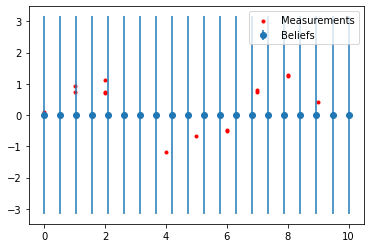

In [10]:
covs = jnp.sqrt(jnp.concatenate(fg.belief_covs()).flatten())
plt.errorbar(xs, fg.belief_means(), yerr=covs, fmt='o', color="C0", label='Beliefs')
plt.scatter(meas_x, meas_y, color="red", label="Measurements", marker=".")
plt.legend()
plt.show()

## Solve with GBP {vertical-output: true}

In [11]:
fg.gbp_solve(n_iters=50)


Initial Energy 106.23512
Iter 1  --- Energy 45.52087 --- 
Iter 2  --- Energy 26.09325 --- 
Iter 3  --- Energy 27.78958 --- 
Iter 4  --- Energy 17.66786 --- 
Iter 5  --- Energy 16.32377 --- 
Iter 6  --- Energy 15.39066 --- 
Iter 7  --- Energy 14.81991 --- 
Iter 8  --- Energy 14.48639 --- 
Iter 9  --- Energy 14.44526 --- 
Iter 10  --- Energy 14.43492 --- 
Iter 11  --- Energy 14.43174 --- 
Iter 12  --- Energy 14.43131 --- 
Iter 13  --- Energy 14.43096 --- 
Iter 14  --- Energy 14.43098 --- 
Iter 15  --- Energy 14.43092 --- 
Iter 16  --- Energy 14.43093 --- 
Iter 17  --- Energy 14.43092 --- 
Iter 18  --- Energy 14.43092 --- 
Iter 19  --- Energy 14.43092 --- 
Iter 20  --- Energy 14.43092 --- 
Iter 21  --- Energy 14.43092 --- 
Iter 22  --- Energy 14.43092 --- 
Iter 23  --- Energy 14.43092 --- 
Iter 24  --- Energy 14.43092 --- 
Iter 25  --- Energy 14.43092 --- 
Iter 26  --- Energy 14.43092 --- 
Iter 27  --- Energy 14.43092 --- 
Iter 28  --- Energy 14.43092 --- 
Iter 29  --- Energy 14.43092 --

## Plot beliefs and measurements

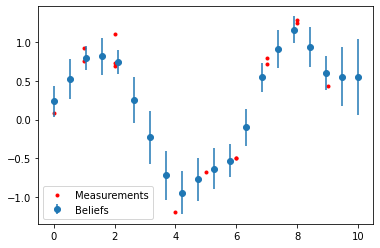

In [12]:
covs = jnp.sqrt(jnp.concatenate(fg.belief_covs()).flatten())
plt.errorbar(xs, fg.belief_means(), yerr=covs, fmt='o', color="C0", label='Beliefs')
plt.scatter(meas_x, meas_y, color="red", label="Measurements", marker=".")
plt.legend()
plt.show()